- $\textbf{Author}$: Patrick L. Mthisi
- $\textbf{Contact details}$: patrickmthisi@hotmail.com

# Project description and objectives:

This study involves the market-based valuation of a portfolio of non-traded American options on the Tesla (TSLA) stock. The option chain data used in the end-to-end project was sourced from Yahoo Finance.  

The main highlights of this project involve:
1. Calibrating our model to market quotes of liquidly traded options.
2. The model used for simulation was a jump-diffusion model, given by:

$$S_{t_{m+1}} = \Big(exp\Big(\Big(r - r_j - \frac{\sigma^2}{2}\Big)(t_{m+1} - t_{m}) + \sigma\sqrt{t_{m+1} - t_{m}}z_{t}^{1}\Big) + \Big(exp(\mu_{j} + \sigma z_{t}^{2}) - 1\Big)y_t\Big) \\n 0 \le t_m \le t_{m+1} \le T$$

3. Using the calibrated model for the pricing of a portfolio of non-traded American put options using Least-square Monte Carlo.
4. Calculating overall the portfolio value, as well as risk metrics such as delta and vega.

# Import the libraries:

In [1]:
# matplotlib configuration
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dx
import datetime
import scipy.optimize as spo
from market_valuation.market_val_utils import get_option_chain_and_price

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(context='notebook', 
              style='whitegrid',
              palette='colorblind', 
              color_codes=True, 
              rc={'figure.figsize': [10, 6]})

# Load market data:

In [2]:
symbol = "TSLA"
desired_expiry_date_dateObject = datetime.date(2025, 9, 19)
option_data = get_option_chain_and_price(symbol, desired_expiry_date_dateObject)

if option_data:
    print(f"Option chain and current price for {symbol} expiring on {desired_expiry_date_dateObject}:")
    print(f"Current Price: {option_data['current_price']}")
    print("Calls:")
    print(option_data["calls"])
    print("\nPuts:")
    print(option_data["puts"])
else:
    print(f"Could not retrieve option chain or price for {symbol} on {desired_expiry_date_dateObject}.")

Option chain and current price for TSLA expiring on 2025-09-19:
Current Price: 315.35
Calls:
          contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0    TSLA250919C00005000 2025-07-03 15:46:24+00:00     5.0     313.05  310.80   
1    TSLA250919C00010000 2025-07-01 13:56:42+00:00    10.0     292.10  305.25   
2    TSLA250919C00015000 2025-06-30 19:27:58+00:00    15.0     302.79  299.00   
3    TSLA250919C00020000 2025-06-24 16:04:52+00:00    20.0     323.74  293.70   
4    TSLA250919C00025000 2025-03-27 13:54:18+00:00    25.0     254.18  259.15   
..                   ...                       ...     ...        ...     ...   
143  TSLA250919C00920000 2025-07-03 15:19:31+00:00   920.0       0.26    0.23   
144  TSLA250919C00930000 2025-07-02 17:18:02+00:00   930.0       0.25    0.19   
145  TSLA250919C00940000 2025-07-03 16:04:10+00:00   940.0       0.24    0.21   
146  TSLA250919C00950000 2025-07-03 14:33:01+00:00   950.0       0.25    0.19   
147  TSLA250919C

# Perform data wrangling:

In [3]:
calls = option_data["calls"]
calls['EXPIR_DATE'] = datetime.date(2025, 9, 19)
calls['lastTradeDate'] = pd.to_datetime(calls['lastTradeDate']).dt.strftime('%Y-%m-%d')
initial_value = option_data['current_price']

In [4]:
for col in ['lastTradeDate', 'EXPIR_DATE']:
    calls[col] = calls[col].apply(lambda date: pd.Timestamp(date))
    
cols = ['contractSymbol', 'lastTradeDate', 'EXPIR_DATE', 'strike', 'lastPrice', 'impliedVolatility']
calls = calls[cols]
    
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   contractSymbol     148 non-null    object        
 1   lastTradeDate      148 non-null    datetime64[ns]
 2   EXPIR_DATE         148 non-null    datetime64[ns]
 3   strike             148 non-null    float64       
 4   lastPrice          148 non-null    float64       
 5   impliedVolatility  148 non-null    float64       
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 7.1+ KB


# Relevant Market Data

In [5]:
limit = 75
option_selection = calls[abs(calls['strike'] - initial_value) < limit].copy()
option_selection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 48 to 77
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   contractSymbol     30 non-null     object        
 1   lastTradeDate      30 non-null     datetime64[ns]
 2   EXPIR_DATE         30 non-null     datetime64[ns]
 3   strike             30 non-null     float64       
 4   lastPrice          30 non-null     float64       
 5   impliedVolatility  30 non-null     float64       
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 1.6+ KB


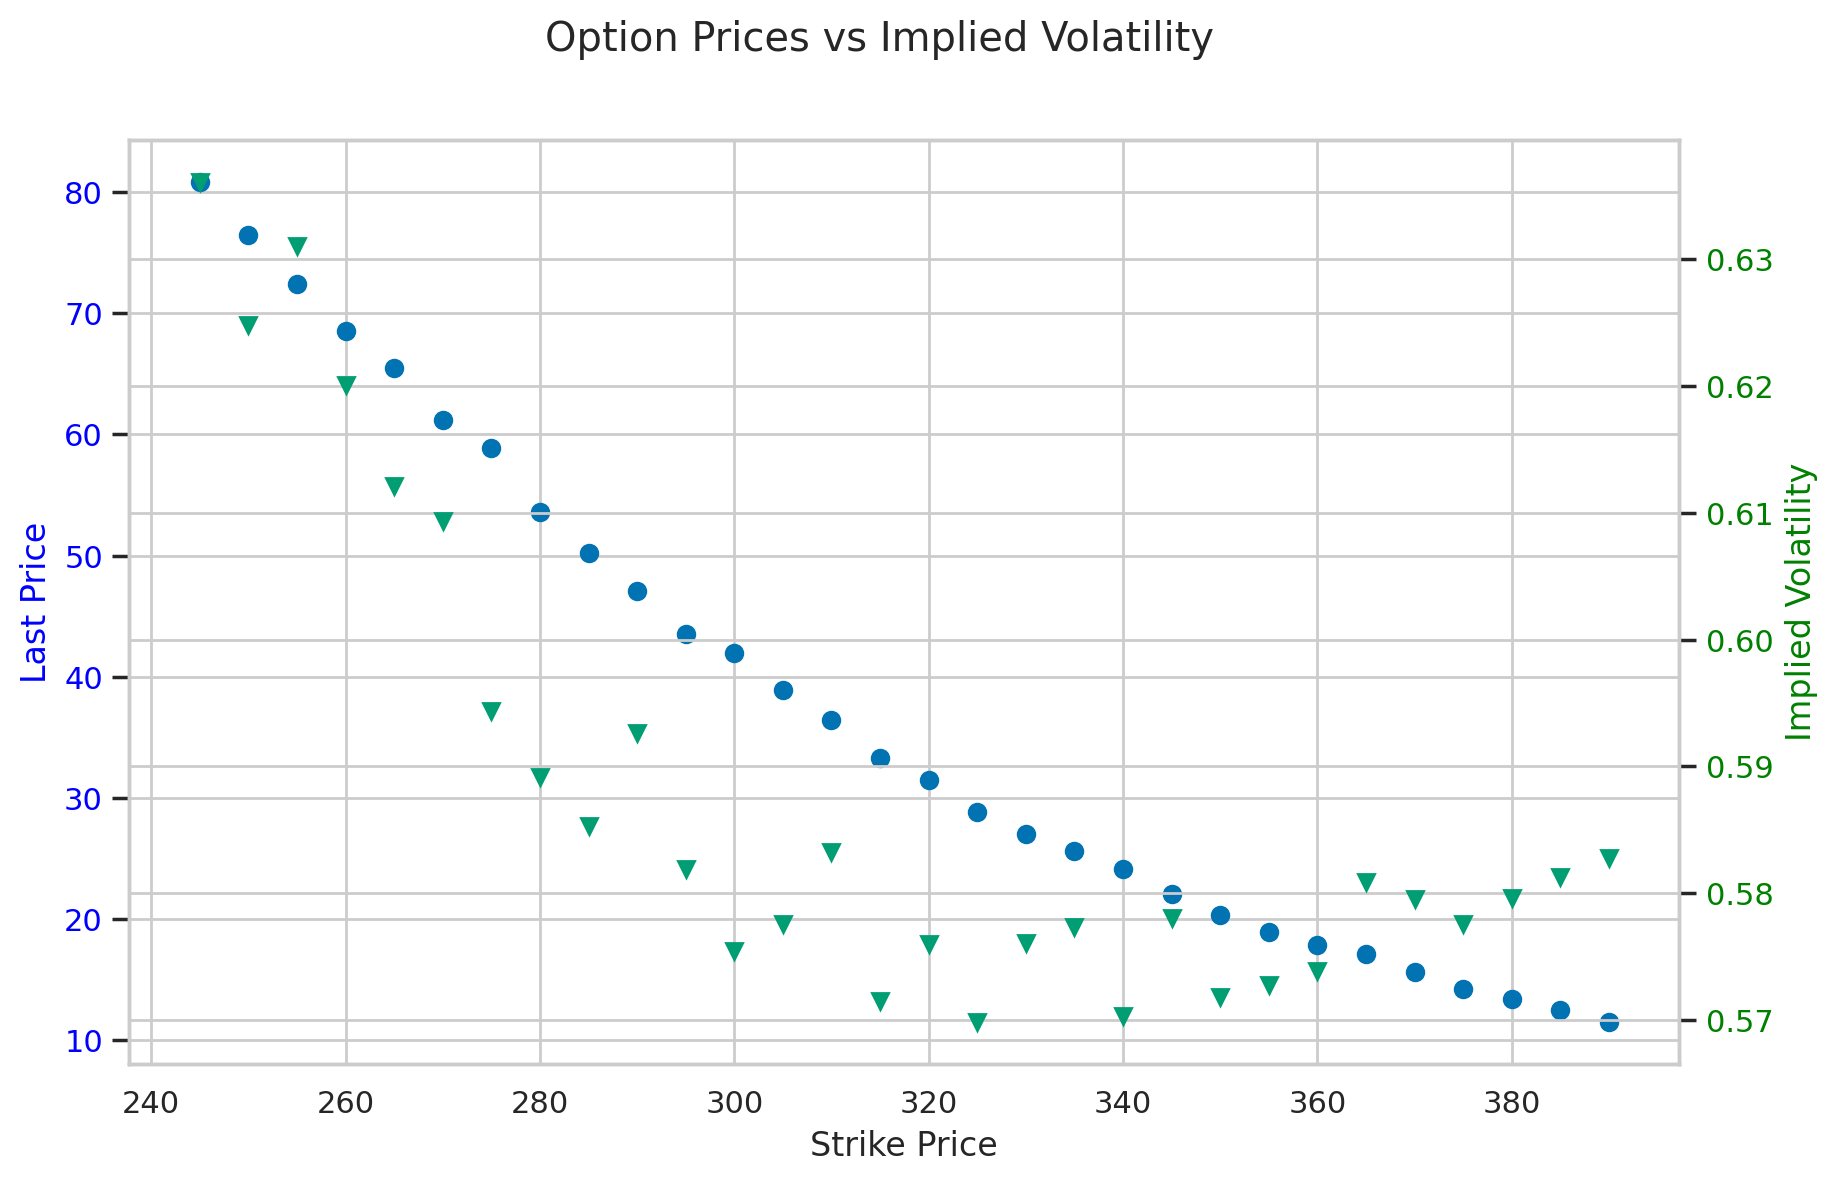

In [162]:
fig, ax1 = plt.subplots()

ax1.plot(
    option_selection['strike'], 
    option_selection['lastPrice'], 
    'bo', 
    label='Last Price'
)
ax1.set_ylabel('Last Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')


ax2 = ax1.twinx()
ax2.plot(
    option_selection['strike'], 
    option_selection['impliedVolatility'], 
    'gv', 
    label='Implied Volatility'
)
ax2.set_ylabel('Implied Volatility', color='green')
ax2.tick_params(axis='y', labelcolor='green')


ax1.set_xlabel('Strike Price')
fig.suptitle('Option Prices vs Implied Volatility');

# Option Modelling

In [7]:
pricing_date = option_selection['lastTradeDate'].max()
me_tsla = dx.market_environment('TLSA', pricing_date)
maturity = pd.Timestamp(calls.iloc[0]['EXPIR_DATE'])

# add basic model parameters
me_tsla.add_constant('initial_value', initial_value)
me_tsla.add_constant('final_date', maturity)
me_tsla.add_constant('currency', 'USD')

In [8]:
# add simulated related parameters
me_tsla.add_constant('frequency', 'B')
me_tsla.add_constant('paths', 25_000)

In [9]:
csr = dx.constant_short_rate('csr', 0.04239) # 6-month T-bill rate
me_tsla.add_curve('discount_curve', csr)

In [10]:
# add model specific parameters for jump diffusion
me_tsla.add_constant('volatility', 0.2)
me_tsla.add_constant('lambda', 0.8)
me_tsla.add_constant('mu', -0.2)
me_tsla.add_constant('delta', 0.1)

In [11]:
tsla_model = dx.jump_diffusion('tsla_model', me_tsla)

In [12]:
# get first approximation value
me_tsla.add_constant('strike', initial_value)
me_tsla.add_constant('maturity', maturity)

In [13]:
payoff_func = 'np.maximum(maturity_value - strike, 0)'

In [14]:
# instantiate valuation object
tsla_eur_call = dx.valuation_mcs_european('tsla_eur_call', tsla_model, me_tsla, payoff_func)

In [15]:
# initiates the simulation and value estimation
%time tsla_eur_call.present_value()

CPU times: user 101 ms, sys: 1.85 ms, total: 103 ms
Wall time: 103 ms


16.3842

In [16]:
option_models = {}
for option in option_selection.index:
    strike = option_selection['strike'].loc[option]
    me_tsla.add_constant('strike',strike)
    option_models[strike] = dx.valuation_mcs_european('eur_call_%d' % strike, tsla_model, me_tsla, payoff_func)

In [17]:
def calculate_model_values(p0):
    volatility, lamb, mu, delta = p0
    tsla_model.update(volatility=volatility, lamb=lamb, mu=mu, delta=delta)
    return {strike: model.present_value(fixed_seed=True) for strike, model in option_models.items()}

# Calibration Procedure

In [18]:
i = 0
def mean_squared_error(p0): 
    global i
    model_values = np.array(list(calculate_model_values(p0).values()))
    market_values = option_selection['lastPrice'].values
    option_diffs = model_values - market_values
    MSE = np.sum(option_diffs ** 2) / len(option_diffs)
    if i % 75 == 0:
        if i == 0:
            print('%4s %6s %6s %6s %6s --> %6s' % ('i', 'vola', 'lambda', 'mu', 'delta', 'MSE'))
        print('%4d %6.3f %6.3f %6.3f %6.3f --> %6.3f' % (i, p0[0], p0[1], p0[2], p0[3], MSE))
    i += 1
    return MSE

In [19]:
%%time
i = 0
opt_global = spo.brute(mean_squared_error, 
                       ((0.569, 0.64, 0.025), # range for volatility
                        (0.1, 0.8, 0.1), # range of jump intensity
                        (-0.4, 0.01, 0.1), # range of average jump size
                        (0.00, 0.121, 0.02)), # range of jump volatility
                       finish=None)

   i   vola lambda     mu  delta -->    MSE
   0  0.569  0.100 -0.400  0.000 -->  1.124
  75  0.569  0.300 -0.400  0.100 -->  3.269
 150  0.569  0.500 -0.300  0.060 -->  3.239
 225  0.569  0.700 -0.200  0.020 -->  2.045
 300  0.594  0.200 -0.200  0.120 -->  3.876
 375  0.594  0.400 -0.100  0.080 -->  3.705
 450  0.594  0.600  0.000  0.040 -->  3.049
 525  0.619  0.200 -0.400  0.000 --> 12.790
 600  0.619  0.400 -0.400  0.100 --> 21.336
 675  0.619  0.600 -0.300  0.060 --> 20.280
CPU times: user 1min 48s, sys: 3.6 s, total: 1min 51s
Wall time: 1min 52s


In [20]:
mean_squared_error(opt_global)

0.9950372096356007

In [21]:
%%time
i = 0
opt_local = spo.fmin(mean_squared_error, opt_global, xtol=0.00001, ftol=0.00001, maxiter=750, maxfun=1500)

   i   vola lambda     mu  delta -->    MSE
   0  0.569  0.300  0.000  0.020 -->  0.995
  75  0.567  0.300  0.000  0.020 -->  0.988
 150  0.567  0.300 -0.000  0.025 -->  0.992
 225  0.552  0.300 -0.012  0.251 -->  0.909
 300  0.526  0.300 -0.019  0.409 -->  0.823
 375  0.526  0.300 -0.019  0.408 -->  0.823
Optimization terminated successfully.
         Current function value: 0.823167
         Iterations: 222
         Function evaluations: 414
CPU times: user 57.5 s, sys: 1.96 s, total: 59.4 s
Wall time: 59.5 s


In [22]:
i = 0
mean_squared_error(opt_local)

   i   vola lambda     mu  delta -->    MSE
   0  0.526  0.300 -0.019  0.408 -->  0.823


0.8231668612123012

In [23]:
option_selection['MODEL'] = np.array(list(calculate_model_values(opt_local).values()))
option_selection['ERRORS_USD'] = (option_selection['MODEL'] - option_selection['lastPrice']) # absolute differences
option_selection['ERRORS_%'] = (option_selection['ERRORS_USD'] / option_selection['lastPrice']) * 100 # deviation percent

In [24]:
option_selection[['MODEL', 'lastPrice', 'ERRORS_USD', 'ERRORS_%']]

,MODEL,lastPrice,ERRORS_USD,ERRORS_%
48,78.927762,80.90,-1.972238,-2.437871
49,74.930466,76.45,-1.519534,-1.987618
50,71.039696,72.42,-1.380304,-1.905971
51,67.264665,68.53,-1.265335,-1.846396
52,63.612685,65.49,-1.877315,-2.866567
53,60.080097,61.20,-1.119903,-1.829907
54,56.671402,58.85,-2.178598,-3.701951
55,53.394777,53.60,-0.205223,-0.382879
56,50.251293,50.23,0.021293,0.042391
57,47.245442,47.10,0.145442,0.308794


In [25]:
# average pricing error in USD
round(option_selection['ERRORS_USD'].mean(), 3)

-0.12

In [26]:
# average pricing error in percent
round(option_selection['ERRORS_%'].mean(), 3)

0.577

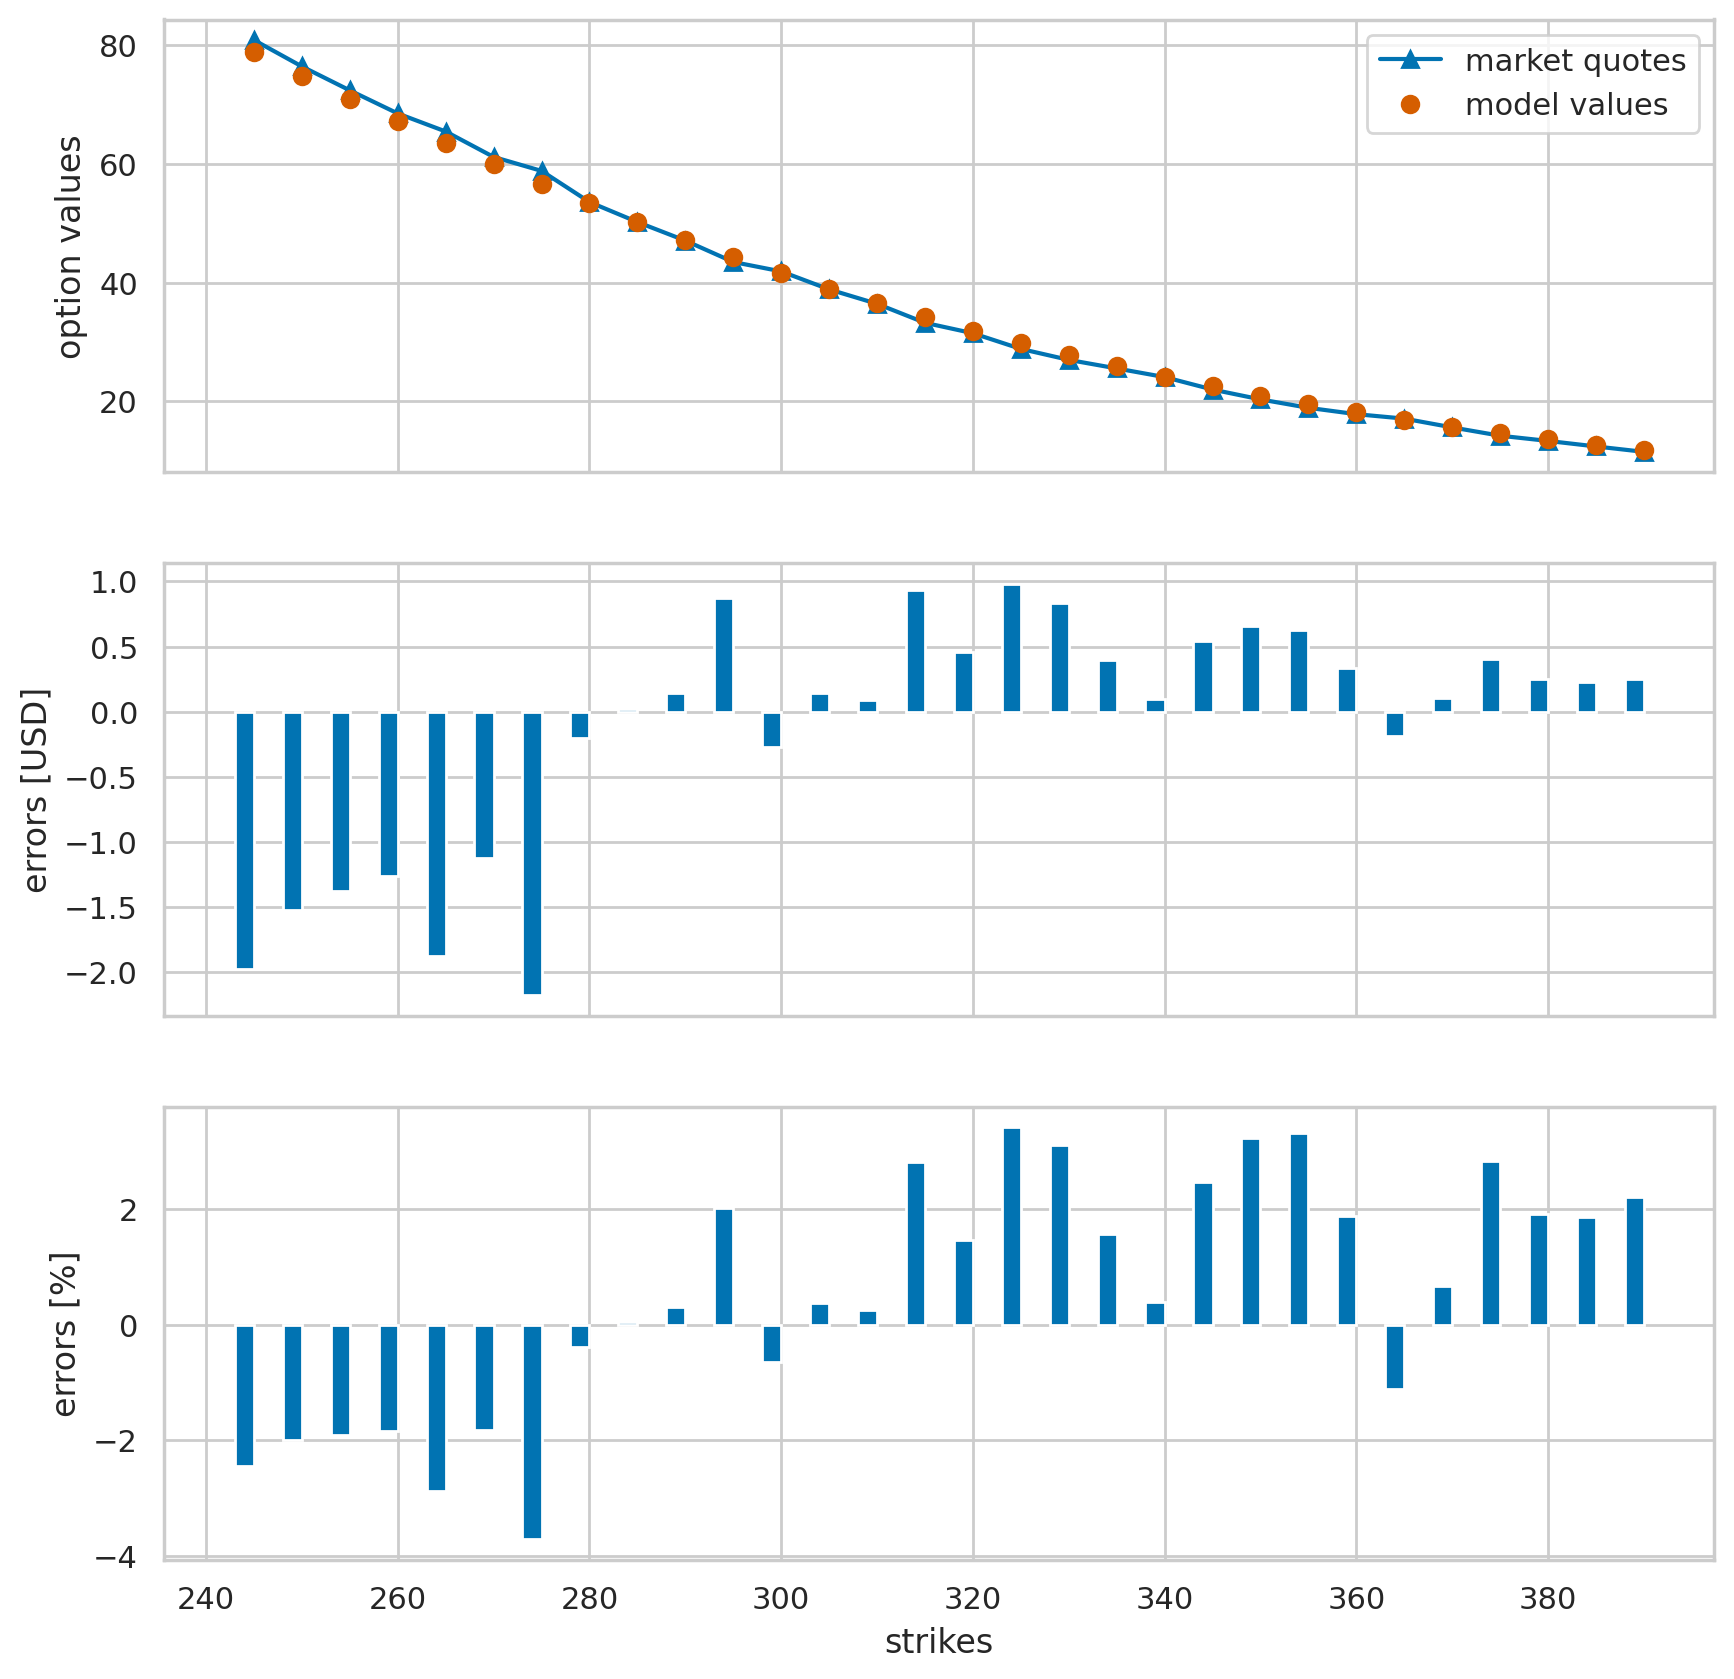

In [157]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(10, 10))
strikes = option_selection['strike'].values
ax1.plot(strikes, option_selection['lastPrice'], 'b^-', label='market quotes')
ax1.plot(strikes, option_selection['MODEL'], 'ro', label='model values')
ax1.set_ylabel('option values')
ax1.legend(loc=0)
wi = 2
ax2.bar(strikes - wi / 2., option_selection['ERRORS_USD'], width=wi)
ax2.set_ylabel('errors [USD]')
ax3.bar(strikes - wi / 2., option_selection['ERRORS_%'], width=wi)
ax3.set_ylabel('errors [%]')
ax3.set_xlabel('strikes');

# Portfolio Valuation
## Modelling Option Positions

In [28]:
me_tsla = dx.market_environment('me_tsla', pricing_date)
me_tsla.add_constant('initial_value', initial_value)
me_tsla.add_constant('final_date', pricing_date)
me_tsla.add_constant('currency', 'USD')

In [29]:
# adds the optimal parameters from the calibration
me_tsla.add_constant('volatility', opt_local[0])
me_tsla.add_constant('lambda', opt_local[1])
me_tsla.add_constant('mu', opt_local[2])
me_tsla.add_constant('delta', opt_local[3])

In [30]:
me_tsla.add_constant('model', 'jd')

In [32]:
payoff_func = 'np.maximum(strike - instrument_values, 0)'

In [33]:
shared = dx.market_environment('share', pricing_date)
shared.add_constant('maturity', maturity)
shared.add_constant('currency', 'USD')

In [34]:
option_positions = {}
option_environments = {}
for option in option_selection.index:
    option_environments[option] = dx.market_environment('am_put_%d' % option, pricing_date)
    strike = option_selection['strike'].loc[option]
    option_environments[option].add_constant('strike', strike)
    option_environments[option].add_environment(shared)
    option_positions['am_put_%d' % strike] = dx.derivatives_position('am_put_%d' % strike, 
                                                                     quantity=np.random.randint(10, 50), 
                                                                     underlying='tsla_model', 
                                                                     mar_env=option_environments[option], 
                                                                     otype='American', 
                                                                     payoff_func=payoff_func)

## Options Portfolio

In [52]:
val_env = dx.market_environment('val_env', pricing_date)
val_env.add_constant('starting_date', pricing_date)
val_env.add_constant('final_date', pricing_date)
val_env.add_curve('discount_curve', csr)
val_env.add_constant('frequency', 'B')
val_env.add_constant('paths', 25_000)

In [53]:
underlyings = {'tsla_model': me_tsla}

In [54]:
portfolio = dx.derivatives_portfolio('portfolio', option_positions, val_env, underlyings)

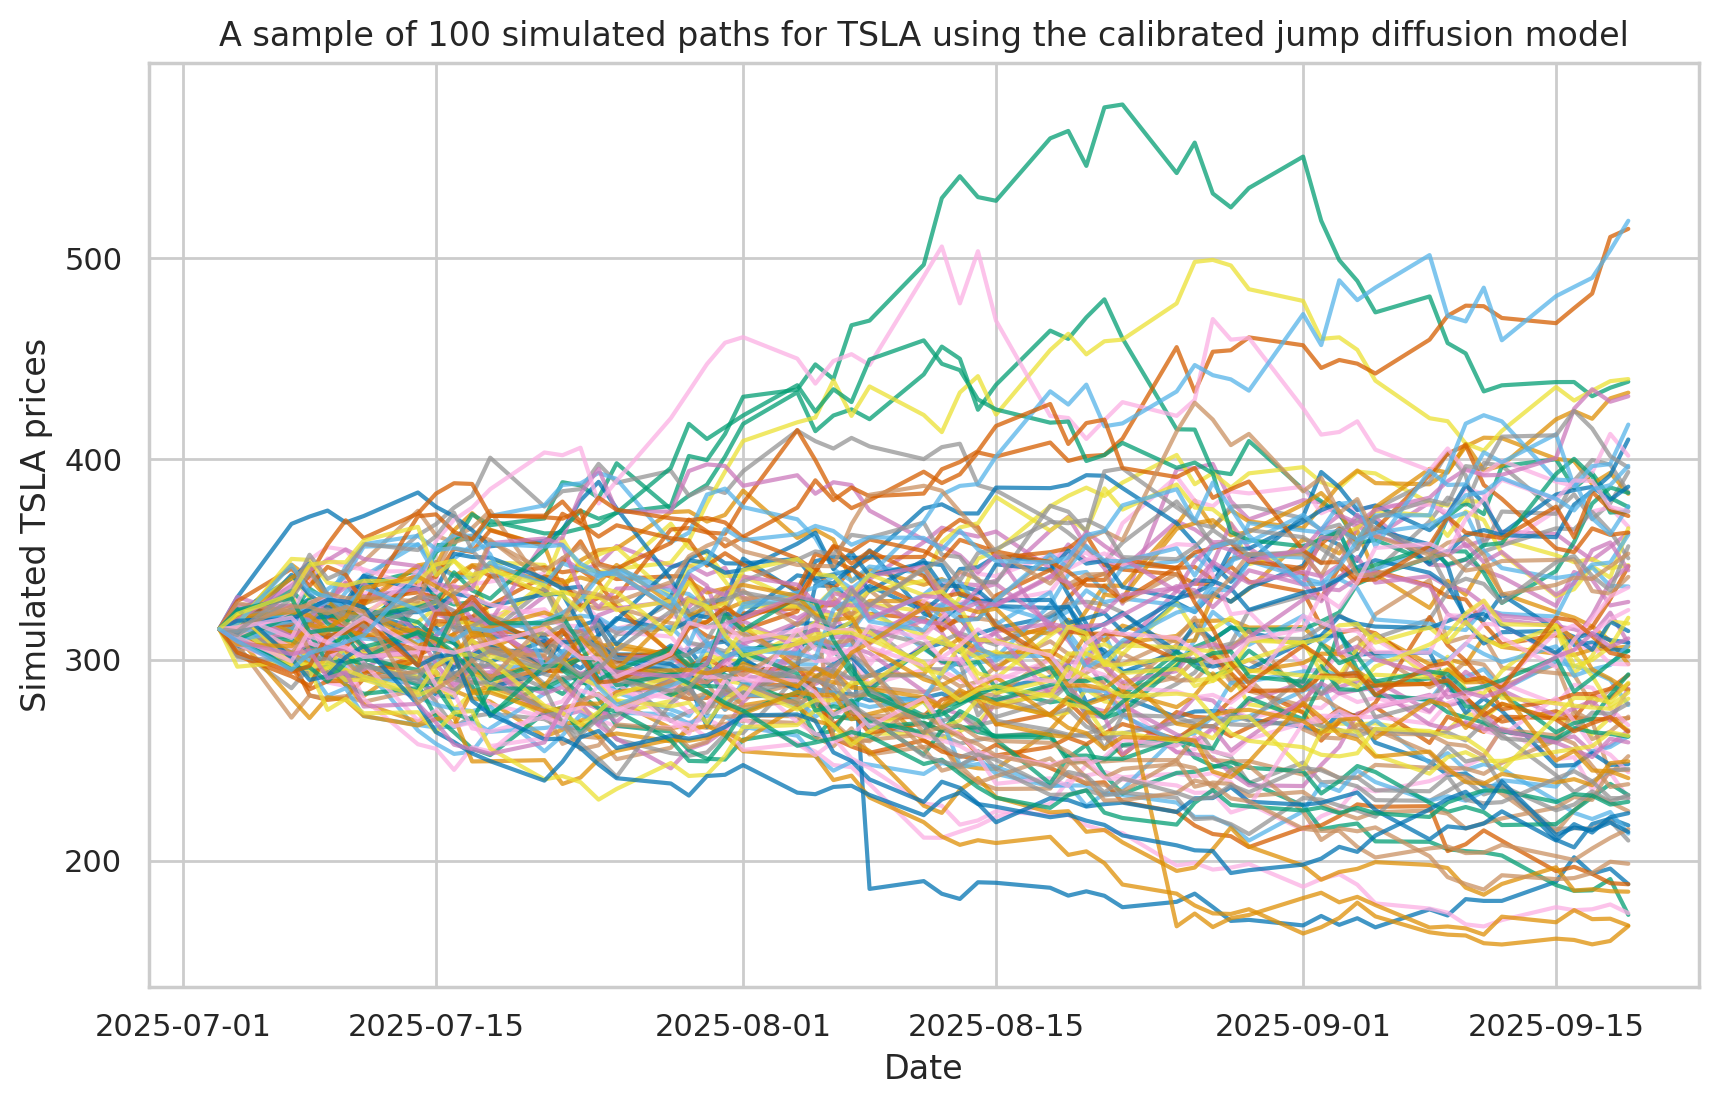

In [161]:
path_jd = portfolio.underlying_objects["tsla_model"].get_instrument_values()[:, 500:600]
plt.figure()
plt.plot(portfolio.time_grid, path_jd, alpha=0.75)
plt.xlabel("Date")
plt.ylabel("Simulated TSLA prices")
plt.title("A sample of 100 simulated paths for TSLA using the calibrated jump diffusion model")

plt.xticks(rotation=0);

In [49]:
%time results = portfolio.get_statistics(fixed_seed=True)

CPU times: user 36.6 s, sys: 25.9 s, total: 1min 2s
Wall time: 31.3 s


In [39]:
results.round(1)

,name,quant,value,curr,pos_value,pos_delta,pos_vega
0,am_put_245,43,5.1,USD,220.7,-4.5,1091.5
1,am_put_250,22,6.0,USD,131.4,-2.5,703.2
2,am_put_255,17,7.0,USD,119.2,-2.5,574.6
3,am_put_260,13,8.1,USD,105.8,-2.1,469.2
4,am_put_265,28,9.4,USD,263.5,-5.1,1063.0
5,am_put_270,26,10.8,USD,280.6,-5.3,1142.8
6,am_put_275,36,12.3,USD,442.5,-8.0,1374.3
7,am_put_280,13,13.8,USD,179.9,-3.0,569.0
8,am_put_285,40,15.5,USD,620.9,-10.3,1901.5
9,am_put_290,29,17.5,USD,506.3,-8.6,1369.7


In [40]:
results[['pos_value', 'pos_delta', 'pos_vega']].sum().round(1)

pos_value    32391.3
pos_delta     -397.2
pos_vega     42843.3
dtype: float64

# Conclusion and recommnendations...

In this project, we calibrated our model using liquidly traded options on TSLA stock to evaluate a portfolio of American put options on TSLA, which expires on September 19, 2025. The model's option values aligned closely with market quotes, as demonstrated by minimal errors measured by the mean squared error (MSE), proving that our model was well-calibrated. We then employed the model to assess a portfolio of non-traded American options on TSLA stock. Additionally, we computed risk metrics such as the portfolio's delta and vega for effective risk management.